In [1]:
import numpy as onp
import pandas as pd
from itertools import product

import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update

import probaflow

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def softmax(u, scale=1, corr_factor=1):
    """ 
    Probability equation for multinomial logit. 
    
    Parameters:
    ------------
    u: array-like. Array containing the utiliy estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    Returns: 
    ----------
    (array) Probabilites for each alternative
    """
    exp_utility = np.exp(scale * u)
    sum_exp_utility = np.sum(exp_utility * corr_factor, keepdims=True)
    proba = exp_utility / sum_exp_utility
    return proba

def logsums(u, scale=1, axis=1, corr_factor=1):
    """ 
    Maximum expected utility 
    Parameters:
    ------------
    u: array-like. Array containing the unscaled utility estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    return: 
    -------
    Maximum expected utility of the nest
    """
    return (1 / scale) * np.log(np.sum(np.exp(scale * u) * corr_factor, axis=axis))

class large_mnl():
    """
    Differentiable approach for multinomial logit with large alternative set 
    """

    def __init__(self, model_object=None, coeffs=None, n_choosers=None, n_alts=None):
        self.weights = coeffs
        self.n_choosers = n_choosers
        self.n_alts = n_alts
        # self.constrains  = constrains 
        ## TO DO: yaml file
            
    def utilities(self, x):
        """ Calculates the utility fuction of weights w and data x 
        Parameters:
        ------------
        x = Jax 2d array, OrcaTable wrapper name, Pandas DataFrame. Column names must match coefficient names.
            if a Jax array, order of columns should be the same order as the coeffient names. 

        Return:
        ------------
        2-d jax numpy array with utilities for eahc alternative.
        """

        w = self.weights
        n = self.n_choosers
        j = self.n_alts
        return np.dot(x, w.T).reshape(n,j)

    def probabilities(self, x, scale=1, corr_factor=1):
        ''' Estimates the probabilities for each alternative in the choice set for each individual '''
        utils = self.utilities(x)
        return vmap(softmax, in_axes=(0, None, None))(utils, scale, corr_factor)

    def logsum(self, x):
        ''' Estimates the maximum expected utility for all alternatives in the choice set
            Scale parameter normalized to 1. 
        '''
        utils = self.utilities(x)
        return vmap(logsums)(utils)

    def simulation(self, x, key):
        ''' 
        Monte Carlo simulation. 
        
        Parameters
        ----------
        x: 2-d Jax numpy array
        key: jax PRNG Key object
        
        Return
        -------
        - numpy.array 

        '''
        utils = self.utilities(x)
        shape = utils.shape
        keys = random.split(key, shape[0])

        @jit
        def single_simulation(u, key):
            return random.categorical(key, u)

        choices = vmap(single_simulation, in_axes=(0, 0))(utils, keys)
        return choices  ### Assuming alternative name starts at 0

In [5]:
def get_mct(choosers, alts, var_mats=None, chooser_alts=None):
    
    n_choosers = len(choosers)
    
    if chooser_alts is None:
        if var_mats:
            mct = np.concatenate(
                [np.concatenate([var_mats[v][c.home_zone, :].reshape(-1, 1) for i, c in choosers.iterrows()], axis=0)
                for v in range(len(var_mats))], axis=1)
        else:
            mct = np.concatenate([alts for i in choosers], axis=0)
    
    else:
        if var_mats:
            mct = np.concatenate(
                [np.concatenate([var_mats[v][c.home_zone, chooser_alts[i, :]].reshape(-1, 1) for i, c in choosers.iterrows()], axis=0)
                for v in range(len(var_list))], axis=1)
        else:
            mct = np.concatenate([alts[chooser_alts[i, :], :] for i in choosers], axis=0)
    
    return mct

# Simulate data 

#### Choosers

In [6]:
n_choosers = 750
persons = onp.array(range(n_choosers))

#### Alternatives (zones)

In [7]:
num_alts = 200
zones = np.array(range(num_alts))

#### Data and coefficients

In [21]:
var_list = ['var1', 'var2', 'var3', 'var4', 'var5']  # i.e. attributes of alts
num_vars = len(var_list)
coeffs = onp.array([.1, .1, .1, .1, .1])

#### Alt attributes

In [22]:
alts = onp.zeros((num_alts, num_vars))

In [23]:
split_val = int(onp.floor(num_alts * .5))
for i in range(num_vars):
    alts[:split_val, i] = onp.random.normal(1, 1, split_val)  # first 1/2 of alts have mean = 1
    alts[split_val:, i] = onp.random.normal(0.5, 1, num_alts - split_val)  # rest of alts have mean 0.5

#### OD skims

In [24]:
# skims = np.column_stack((np.repeat(zones, num_alts), np.tile(zones, num_alts)))
# size_long = skims.shape[0]
# skim_mats = []
# for var in var_list:
#     skim_mats.append(onp.random.uniform(0, 5, size_long).reshape(num_alts, num_alts))

# Simulate choices -- no sampling

In [25]:
model = large_mnl(coeffs=coeffs, n_choosers=n_choosers, n_alts=num_alts)

In [26]:
mct = get_mct(persons, alts)

In [27]:
deterministic = model.utilities(mct)

Gumbel distributed error

<AxesSubplot:ylabel='Count'>

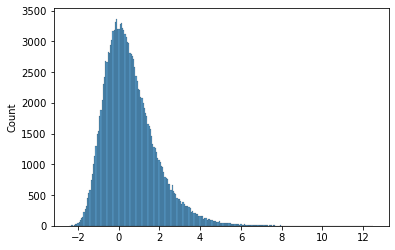

In [28]:
random_err = -np.log(-np.log(onp.random.uniform(size=deterministic.shape)))
sns.histplot(random_err.flatten())

In [29]:
utils_true = deterministic + random_err

In [30]:
true_choices = utils_true.argmax(axis=1)

Text(0.5, 1.0, 'choice frequency')

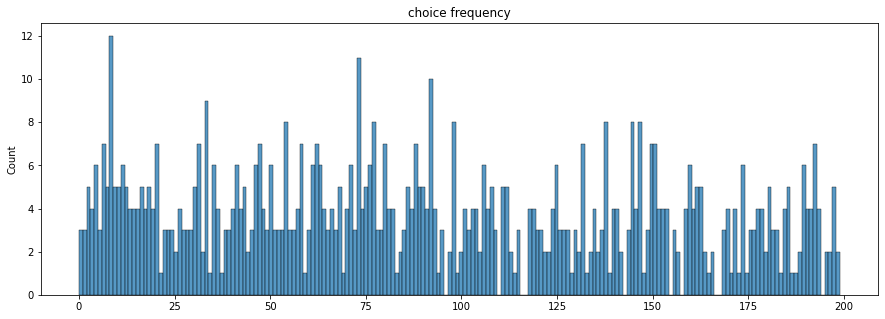

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(onp.array(true_choices), ax=ax, bins=200)
ax.set_title('choice frequency')

In [109]:
%%time
probs_true = model.probabilities(mct)

CPU times: user 12.3 ms, sys: 4.42 ms, total: 16.7 ms
Wall time: 11.1 ms


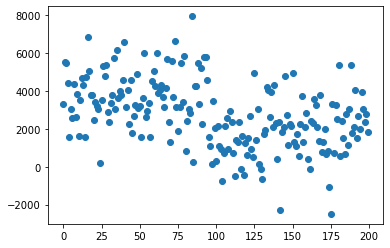

In [266]:
fig, ax = plt.subplots()
ax.scatter(zones, deterministic.sum(axis=0))


#### Without interaction terms, distribution is same for all choosers

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 290 ms


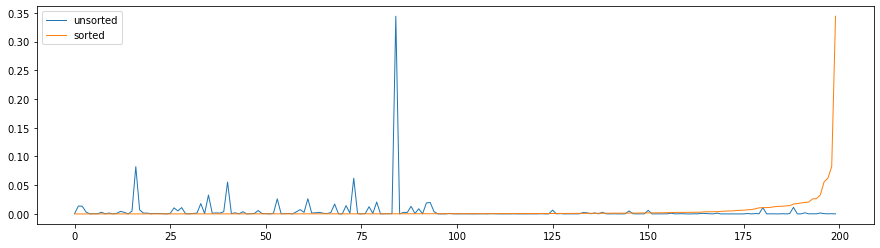

In [110]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_true:
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=1, label='unsorted')
    sns.lineplot(x=range(len(row)), y=np.sort(row), ax=ax, lw=1, label='sorted')
    break

# With sampling

In [142]:
sample_size = 50
chooser_alts = np.vstack([onp.random.choice(
    zones, size=sample_size, replace=False) for chooser in persons])

In [143]:
%%time
mct_sampled = get_mct(persons, alts, chooser_alts=chooser_alts)
model = large_mnl(coeffs=coeffs, n_choosers=n_choosers, n_alts=sample_size)
probs_samp = model.probabilities(mct_sampled)

CPU times: user 1.16 s, sys: 373 ms, total: 1.53 s
Wall time: 891 ms


CPU times: user 8.2 s, sys: 63.4 ms, total: 8.26 s
Wall time: 8.13 s


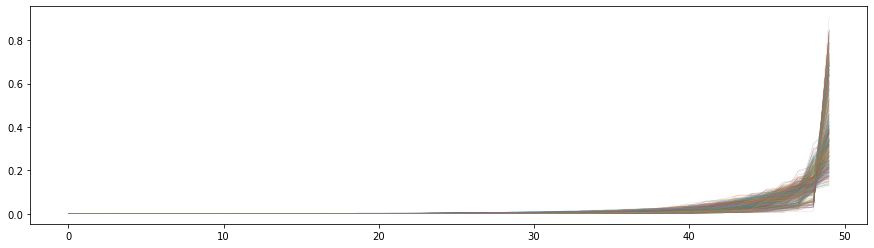

In [144]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_samp.sort(axis=1):
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=0.1)

<AxesSubplot:ylabel='Density'>

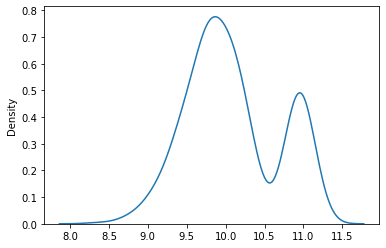

In [145]:
sns.kdeplot(logsums(model.utilities(mct_sampled)))

# Sampling with correction factor

In [149]:
sample_rate = sample_size / num_alts
corr_fac = 1 / sample_rate

In [150]:
probs_samp_corr = model.probabilities(mct_sampled, corr_factor=corr_fac)

CPU times: user 8.29 s, sys: 0 ns, total: 8.29 s
Wall time: 8.29 s


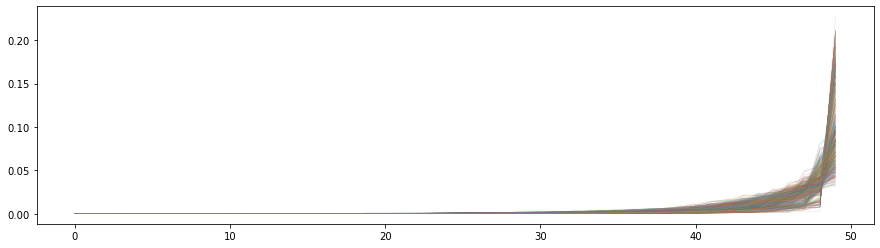

In [151]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_samp_corr.sort(axis=1):
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=0.1)

# Comparison 

Convert sampled probs matrix to sparse matrix of the same shape as the unsampled (true) probs

In [152]:
probs_samp_sparse = onp.zeros_like(probs_true)
probs_samp_sparse[
    np.array(range(n_choosers)).repeat(sample_size), chooser_alts.flatten()] = probs_samp.flatten()

Get submatrix of true probs that correspond to the sampled probs computed for the chooser-alts

In [153]:
probs_true_sampled_rows = []
for i in range(len(chooser_alts)):
    chooser_alts_row = chooser_alts[i, :]
    probs_true_sampled_rows.append(probs_true[i, chooser_alts_row])

In [154]:
probs_true_sampled = np.concatenate([row for row in probs_true_sampled_rows]).reshape(n_choosers, sample_size)

## Probability massing across alterntaives

In [155]:
order = probs_true.sum(axis=0).argsort()[::-1]

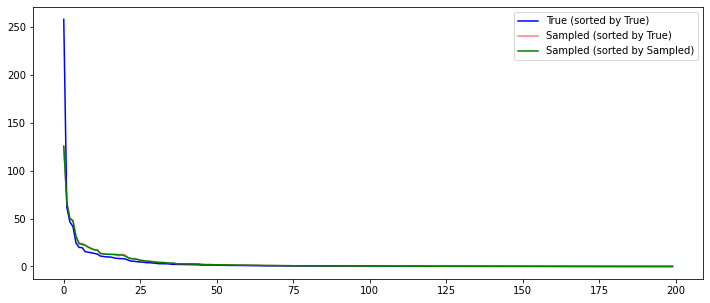

In [156]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(zones, probs_true.sum(axis=0)[order], color='b', alpha=1, label='True (sorted by True)')
ax.plot(zones, probs_samp_sparse.sum(axis=0)[order], color='r', alpha=0.5, label='Sampled (sorted by True)')
ax.plot(zones, np.sort(probs_samp_sparse.sum(axis=0))[::-1], color='g', alpha=1, label='Sampled (sorted by Sampled)')
ax.legend()

(-5.0, 100.0)

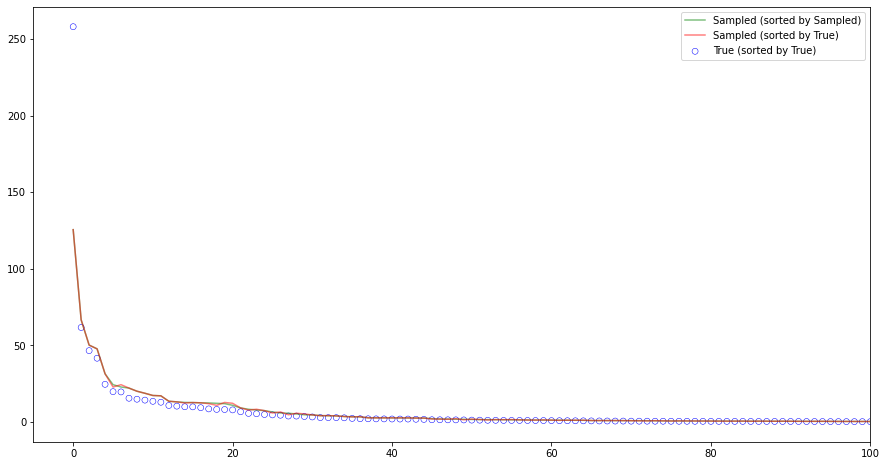

In [157]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(zones, probs_true.sum(axis=0)[order], marker='o',facecolor='none', edgecolor='b', lw=0.5,label='True (sorted by True)')
ax.plot(zones, np.sort(probs_samp_sparse.sum(axis=0))[::-1], color='g', alpha=0.5, label='Sampled (sorted by Sampled)')
ax.plot(zones, probs_samp_sparse.sum(axis=0)[order], color='r', alpha=0.5, label='Sampled (sorted by True)')
ax.legend()
ax.set_xlim(-5,100)

Text(0.5, 1.0, 'probability massing of alternatives')

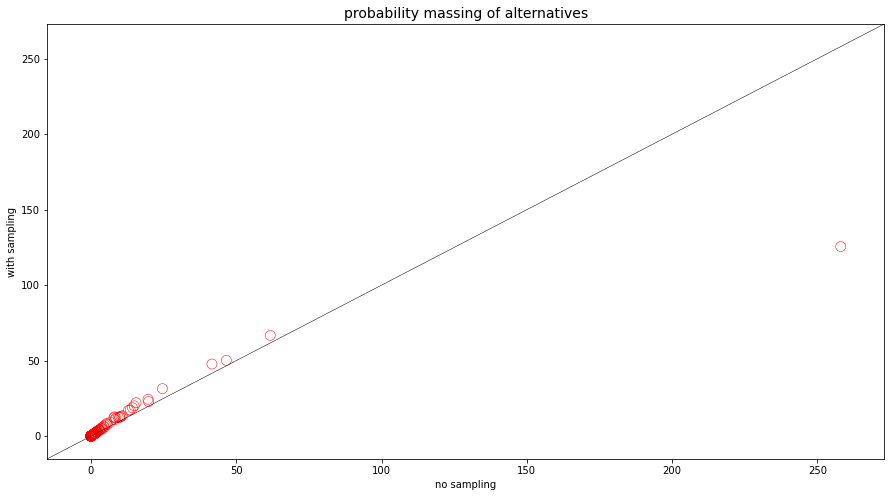

In [158]:
margin = 15
true_massing = probs_true.sum(axis=0)
sampled_massing = probs_samp_sparse.sum(axis=0)
min_x = min_y = min(true_massing.min(), sampled_massing.min()) - margin
max_x = max_y = max(true_massing.max(), sampled_massing.max()) + margin
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot([min_x, max_x],[min_y, max_y], 'k', lw=0.5, label='y=x')
ax.scatter(true_massing, sampled_massing, marker='o', facecolor='none', edgecolor='r', lw=0.5, s=100, )
ax.set_ylim(min_y, max_y)
ax.set_xlim(min_x, max_y)
ax.set_ylabel('with sampling')
ax.set_xlabel('no sampling')
ax.set_title('probability massing of alternatives', fontsize=14)

In [36]:
print(np.corrcoef(true_massing, sampled_massing))

[[1.         0.9414846 ]
 [0.9414846  0.99999994]]


## Mean Error Across Alts for Choosers

In [159]:
err_mat = probs_true_sampled - probs_samp
abs_err = onp.abs(err_mat)
abs_pct_err = abs_err / probs_true_sampled
sq_err = np.square(err_mat)

err_mat_corr = probs_true_sampled - probs_samp_corr
abs_err_corr = onp.abs(err_mat_corr)
abs_pct_err_corr = abs_err_corr / probs_true_sampled
sq_err_corr = np.square(err_mat_corr)

Why is abs pct err ~fixed for each chooser?

In [160]:
abs_pct_err

DeviceArray([[3.1388433 , 3.1388433 , 3.1388433 , ..., 3.1388428 ,
              3.1388433 , 3.1388428 ],
             [2.9173892 , 2.9173892 , 2.9173892 , ..., 2.9173892 ,
              2.9173887 , 2.9173894 ],
             [1.133277  , 1.1332773 , 1.1332773 , ..., 1.1332772 ,
              1.1332772 , 1.1332772 ],
             ...,
             [5.1662116 , 5.1662107 , 5.1662116 , ..., 5.166211  ,
              5.1662116 , 5.166212  ],
             [0.8585243 , 0.85852426, 0.8585245 , ..., 0.8585243 ,
              0.8585243 , 0.8585244 ],
             [3.1193194 , 3.1193197 , 3.11932   , ..., 3.1193194 ,
              3.1193197 , 3.1193197 ]], dtype=float32)

In [161]:
mean_abs_err = abs_err.mean(axis=1).flatten()
mean_abs_err_corr = abs_err_corr.mean(axis=1).flatten()
mean_abs_pct_err = abs_pct_err.mean(axis=1).flatten()
mean_abs_pct_err_corr = abs_pct_err_corr.mean(axis=1).flatten()
rmse = np.sqrt(sq_err.mean(axis=1).flatten())
rmse_corr = np.sqrt(sq_err_corr.mean(axis=1).flatten())

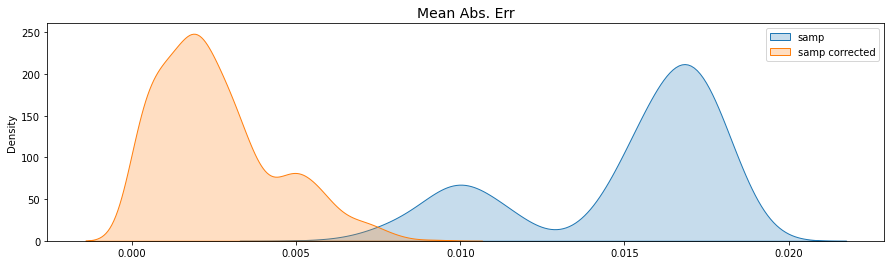

In [162]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("Mean Abs. Err", fontsize=14)
sns.kdeplot(mean_abs_err, label='samp', fill=True, ax=ax)
sns.kdeplot(mean_abs_err_corr, label='samp corrected', fill=True, ax=ax)
ax.legend()

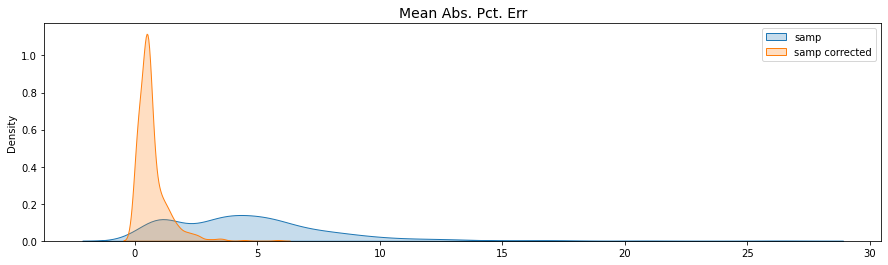

In [163]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("Mean Abs. Pct. Err", fontsize=14)
sns.kdeplot(mean_abs_pct_err, label='samp', fill=True, ax=ax)
sns.kdeplot(mean_abs_pct_err_corr, label='samp corrected', fill=True, ax=ax)
ax.legend()

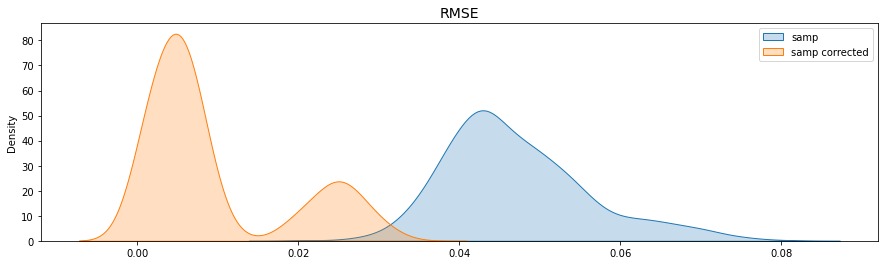

In [164]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("RMSE", fontsize=14)
sns.kdeplot(rmse, label='samp', fill=True, ax=ax)
sns.kdeplot(rmse_corr, label='samp corrected', fill=True, ax=ax)
ax.legend()

#### Example chooser err

Error scales with prob

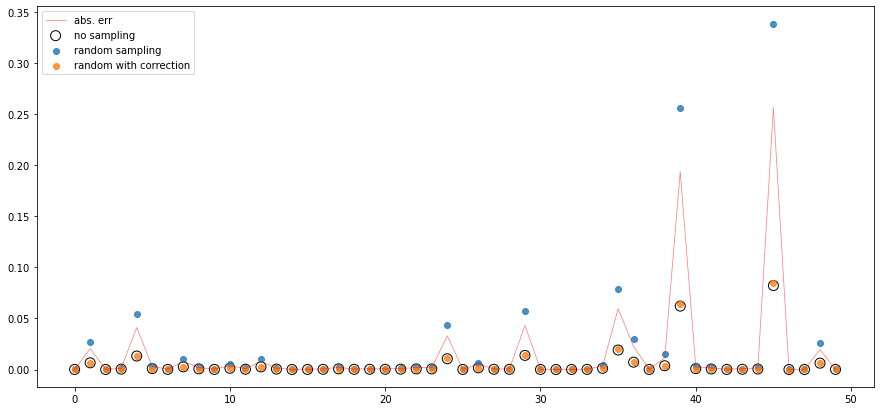

In [165]:
fig, ax = plt.subplots(figsize=(15,7))
person_id = 1000
ax.scatter(
    x=range(sample_size), y=probs_true[person_id, chooser_alts[person_id, :]],
    s=100, marker='o',facecolor='none', edgecolor='k', label='no sampling')
ax.scatter(x=range(sample_size), y=probs_samp[person_id], alpha=0.8, label='random sampling')
ax.scatter(x=range(sample_size), y=probs_samp_corr[person_id], alpha=0.8, label='random with correction')
abs_err = onp.abs(probs_true[person_id, chooser_alts[person_id, :]] - probs_samp[person_id])
abs_pct_err = abs_err / probs_true[person_id, chooser_alts[person_id, :]]
ax.plot(range(sample_size), abs_err, c='r', lw=0.75, alpha=0.5, label='abs. err')
ax.legend()

## Max. prob across choosers

In [166]:
probs_true_max = probs_true_sampled.max(axis=1)
probs_samp_corr_max = probs_samp_corr.max(axis=1)
probs_samp_max = probs_samp.max(axis=1)

Text(0.5, 1.0, 'Probability of Highest Utility Alt')

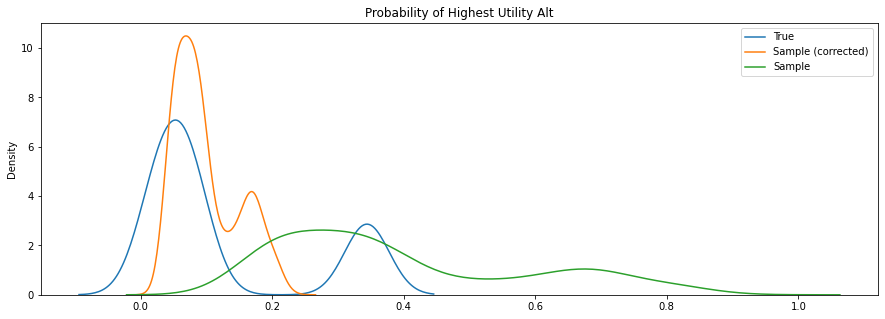

In [167]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(probs_true_max, ax=ax, label='True')
sns.kdeplot(probs_samp_corr_max, ax=ax, label='Sample (corrected)')
sns.kdeplot(probs_samp_max, ax=ax, label='Sample')

ax.legend()
ax.set_title("Probability of Highest Utility Alt")

Text(0, 0.5, 'Sampling')

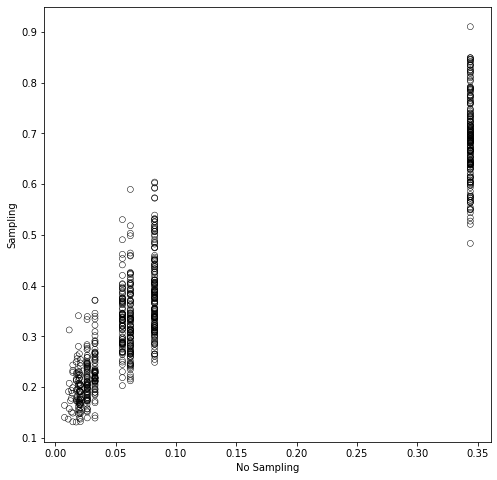

In [168]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(probs_true_max, probs_samp_max, marker='o', facecolor='none', edgecolor='k', lw=0.5)
ax.set_xlabel("No Sampling")
ax.set_ylabel("Sampling")

In [169]:
err_mat_max = probs_true_max - probs_samp_max
abs_err_max = onp.abs(err_mat_max)
abs_pct_err_max = abs_err_max / probs_true_max
sq_err_max = np.square(err_mat_max)

err_mat_corr_max = probs_true_max - probs_samp_corr_max
abs_err_corr_max = onp.abs(err_mat_corr_max)
abs_pct_err_corr_max = abs_err_corr_max / probs_true_max
sq_err_corr_max = np.square(err_mat_corr_max)

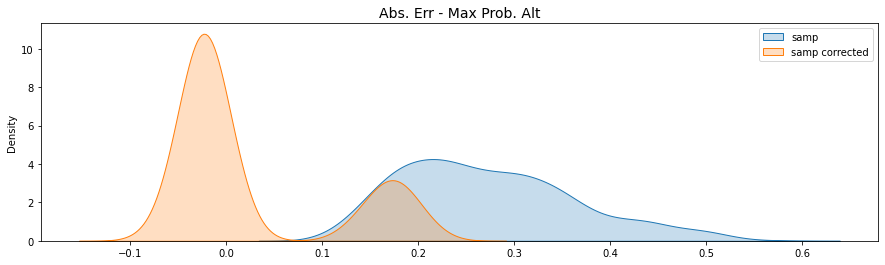

In [170]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("Abs. Err - Max Prob. Alt", fontsize=14)
sns.kdeplot(abs_err_max, label='samp', fill=True, ax=ax)
sns.kdeplot(err_mat_corr_max, label='samp corrected', fill=True, ax=ax)
ax.legend()

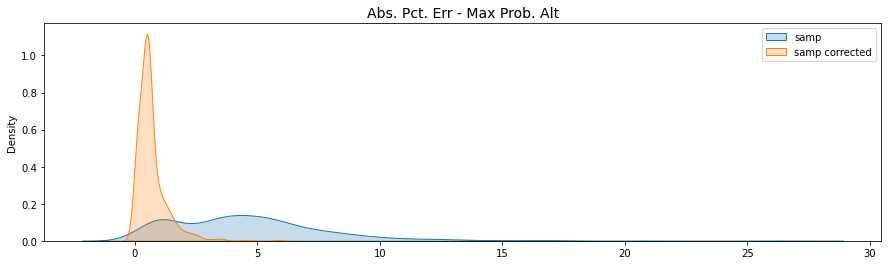

In [171]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("Abs. Pct. Err - Max Prob. Alt", fontsize=14)
sns.kdeplot(abs_pct_err_max, label='samp', fill=True, ax=ax)
sns.kdeplot(abs_pct_err_corr_max, label='samp corrected', fill=True, ax=ax)
ax.legend()

# Iterations 

In [111]:
samp_probs_dict = {}
samp_sizes = [200, 150, 100, 50, 25, 10, 5, 1]

In [112]:
for sample_size in samp_sizes:
    print(sample_size)
    chooser_alts = np.vstack([onp.random.choice(
        zones, size=sample_size, replace=False) for chooser in persons])
    mct_sampled = get_mct(persons, alts, chooser_alts=chooser_alts)
    model = large_mnl(coeffs=coeffs, n_choosers=n_choosers, n_alts=sample_size)
    probs_samp = model.probabilities(mct_sampled)
    probs_true_samp = probs_true[np.array(range(n_choosers)).repeat(sample_size), chooser_alts.flatten()].reshape(n_choosers, sample_size)
    abs_diff_arr = onp.abs(probs_true_samp - probs_samp)
    probs_samp_sparse = onp.zeros_like(probs_true)
    probs_samp_sparse[
        np.array(range(n_choosers)).repeat(sample_size), chooser_alts.flatten()] = probs_samp.flatten()
    
    sample_rate = sample_size / num_alts
    corr_fac = 1 / sample_rate
    probs_samp_corr = model.probabilities(mct_sampled, corr_factor=corr_fac)
    
    samp_probs_dict[sample_size] = {
        'probs_samp': probs_samp, 'probs_true_samp': probs_true_samp, 'diff_arr': abs_diff_arr,
        'probs_samp_sparse': probs_samp_sparse, 'probs_samp_corr': probs_samp_corr}


200
150
100
50
25
10
5
1


Text(0.5, 1.0, 'Mean probability across choosers -- uncorrected')

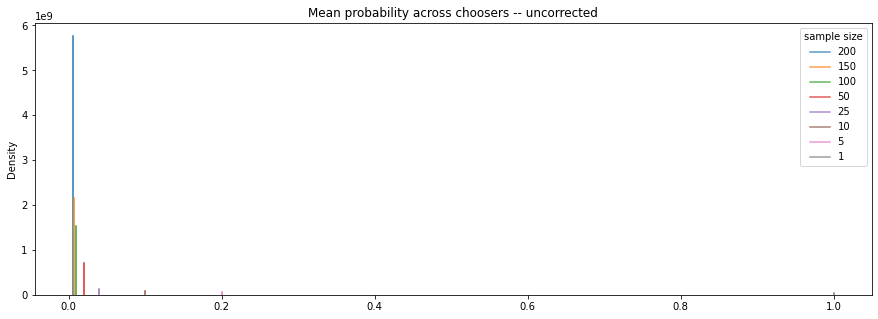

In [188]:
fig, ax = plt.subplots(figsize=(15,5))
probs_true_mean = probs_true.mean(axis=1)
for sample_size in samp_sizes:
    probs_samp_mean = samp_probs_dict[sample_size]['probs_samp'].mean(axis=1)
    sns.kdeplot(probs_samp_mean, ax=ax, label=sample_size, alpha=0.75)
# sns.kdeplot(probs_true_mean[0], ax=ax, label='True', c='k', linewidth=1.5)
ax.legend(title='sample size')
ax.set_title('Mean probability across choosers -- uncorrected')

Text(0.5, 1.0, 'Max probability across choosers -- uncorrected')

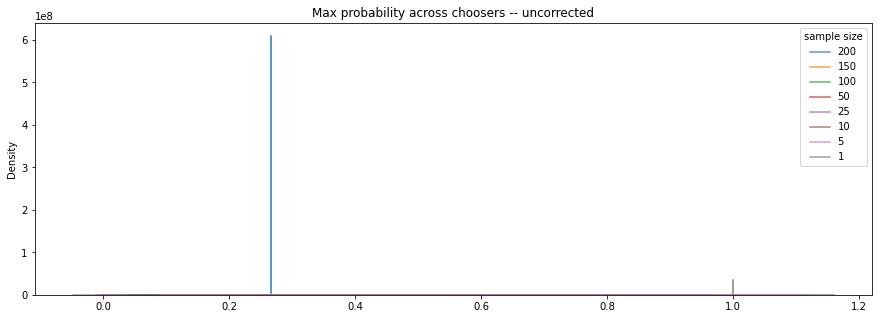

In [190]:
fig, ax = plt.subplots(figsize=(15,5))
probs_true_max = probs_true.max(axis=1)
for sample_size in samp_sizes:
    probs_samp_max = samp_probs_dict[sample_size]['probs_samp'].max(axis=1)
    sns.kdeplot(probs_samp_max, ax=ax, label=sample_size, alpha=0.75)
# sns.kdeplot(probs_true_max, ax=ax, label='True', c='k', linewidth=1.5)
ax.legend(title='sample size')
ax.set_title('Max probability across choosers -- uncorrected')

/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Max probability across choosers -- corrected')

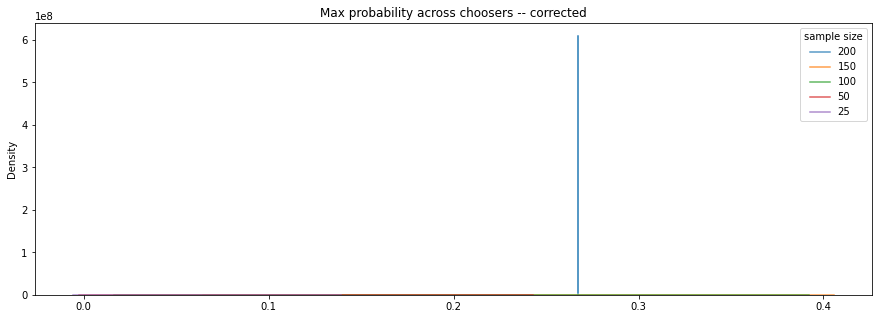

In [191]:
fig, ax = plt.subplots(figsize=(15,5))
probs_true_max = probs_true.max(axis=1)
for sample_size in samp_sizes:
    if sample_size < 25:
        continue
    probs_samp_max = samp_probs_dict[sample_size]['probs_samp_corr'].max(axis=1)
    sns.kdeplot(probs_samp_max, ax=ax, label=sample_size, alpha=0.75)
sns.kdeplot(probs_true_max, ax=ax, label='True', c='k', linewidth=1.5)
ax.legend(title='sample size')
ax.set_title('Max probability across choosers -- corrected')

/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Max probability across choosers -- normalized')

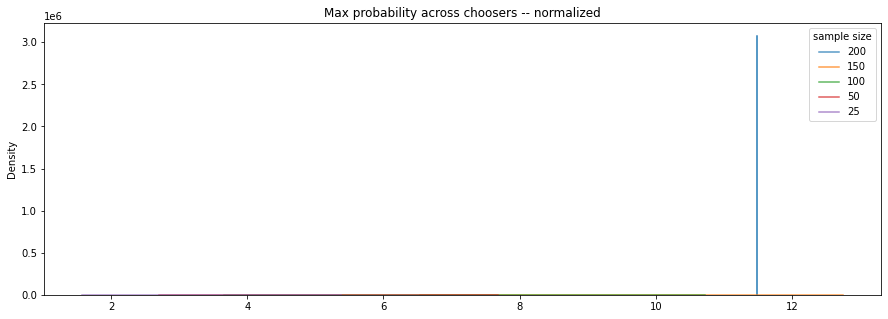

In [192]:
fig, ax = plt.subplots(figsize=(15,5))
probs_true_max_normed = (probs_true.max(axis=1) - probs_true.mean(axis=1))/probs_true.std(axis=1)
for sample_size in samp_sizes:
    if sample_size < 25:
        continue
    probs_samp_max_normed = (samp_probs_dict[sample_size]['probs_samp'].max(axis=1) - samp_probs_dict[sample_size]['probs_samp'].mean(axis=1)) / samp_probs_dict[sample_size]['probs_samp'].std(axis=1)
    sns.kdeplot(probs_samp_max_normed, ax=ax, label=sample_size, alpha=0.75)
sns.kdeplot(probs_true_max_normed, ax=ax, label='True', c='k', linewidth=1.5)
ax.legend(title='sample size')
ax.set_title('Max probability across choosers -- normalized')

Text(0.5, 1.0, 'Mean probability error across choosers')

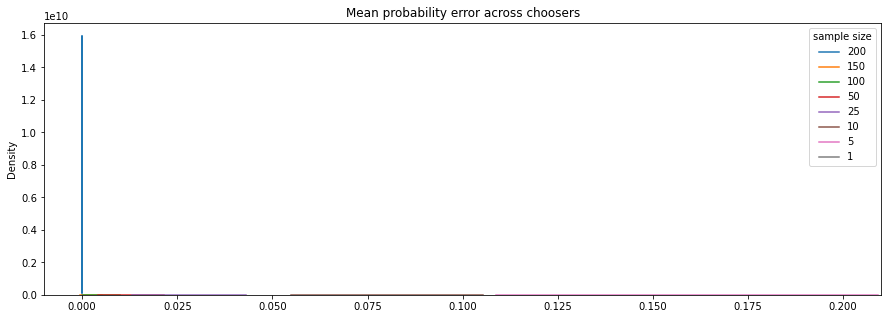

In [193]:
fig, ax = plt.subplots(figsize=(15,5))
for sample_size in samp_sizes:
    diff_arr = samp_probs_dict[sample_size]['diff_arr']
    avg_diff_no_corr = diff_arr.mean(axis=1)
    sns.kdeplot(avg_diff_no_corr.flatten(), ax=ax, label=sample_size)
ax.legend(title='sample size')
ax.set_xlim(-0.01, 0.21)
ax.set_title('Mean probability error across choosers')

(-12.899920654296876, 270.9010134682961)

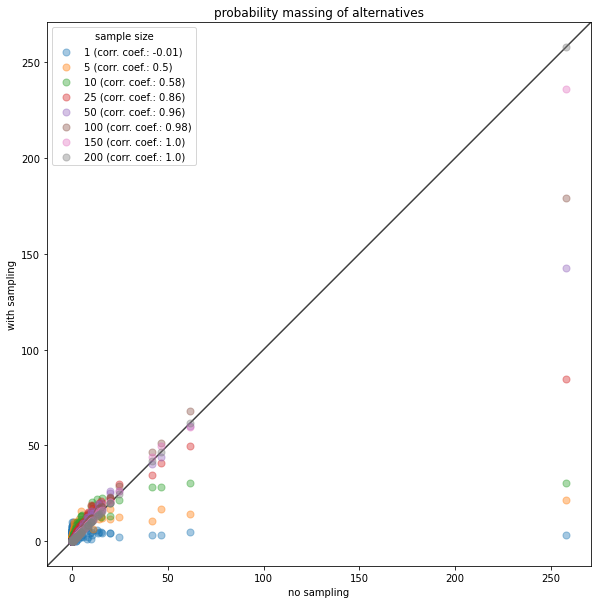

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
for sample_size in samp_sizes[::-1]:
#     if sample_size < 100:
#         continue
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    true_massing = probs_true.sum(axis=0)
    sampled_massing = probs_samp_sparse.sum(axis=0)
    corr_coeff = str(onp.round(float(onp.corrcoef(true_massing, sampled_massing)[0,1]), 2))
    ax.scatter(true_massing, sampled_massing, marker='o', alpha=0.4, label=str(sample_size) + ' (corr. coef.: {0})'.format(corr_coeff), s=50)
    ax.set_ylabel('with sampling')
    ax.set_xlabel('no sampling')
    ax.set_title('probability massing of alternatives')
    ax.legend(title='sample size')
    
lims = [
    min(min(ax.get_xlim()), min(ax.get_ylim())),  # min of both axes
    max(max(ax.get_xlim()), max(ax.get_ylim())),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [126]:
np.corrcoef(true_massing, sampled_massing)

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float32)

(-1.0, 15.0)

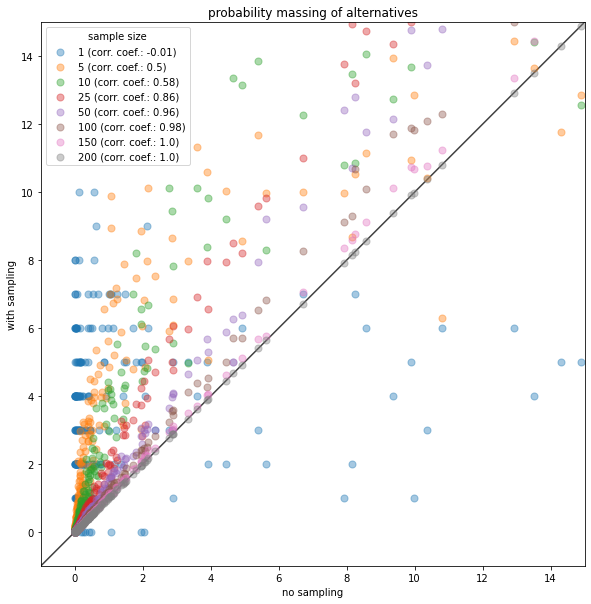

In [139]:
fig, ax = plt.subplots(figsize=(10,10))
for sample_size in samp_sizes[::-1]:
#     if sample_size < 100:
#         continue
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    true_massing = probs_true.sum(axis=0)
    sampled_massing = probs_samp_sparse.sum(axis=0)
    corr_coeff = str(onp.round(float(onp.corrcoef(true_massing, sampled_massing)[0,1]), 2))
    ax.scatter(true_massing, sampled_massing, marker='o', alpha=0.4, label=str(sample_size) + ' (corr. coef.: {0})'.format(corr_coeff), s=50)
    ax.set_ylim(-1, 15)
    ax.set_xlim(-1, 15)
    ax.set_ylabel('with sampling')
    ax.set_xlabel('no sampling')
    ax.set_title('probability massing of alternatives')
    ax.legend(title='sample size')
    
lims = [
    min(min(ax.get_xlim()), min(ax.get_ylim())),  # min of both axes
    max(max(ax.get_xlim()), max(ax.get_ylim())),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

/tmp/ipykernel_2164745/2328707008.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(lims)


(-23.344604539871217, 516.8123255704296)

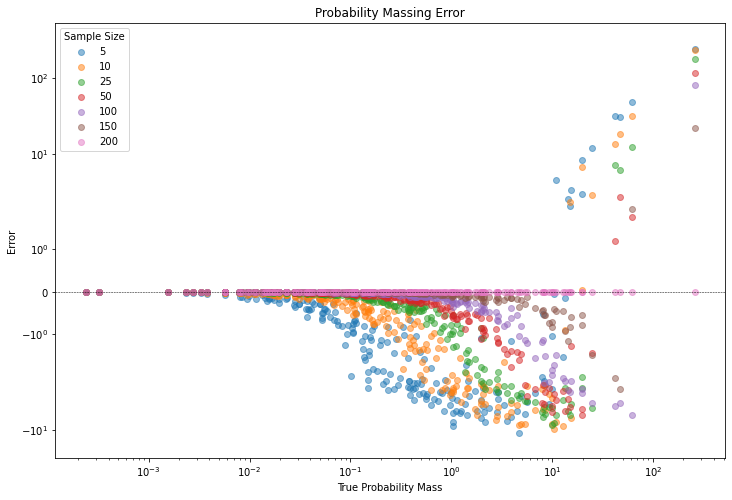

In [249]:
true_massing = probs_true.sum(axis=0)
order = true_massing.argsort()[::-1]

fig, ax = plt.subplots(figsize=(12,8))
for sample_size in samp_sizes[::-1]:
    if sample_size < 5:
        continue
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    sampled_massing = probs_samp_sparse.sum(axis=0)
    massing_err = (true_massing - sampled_massing)
    ax.scatter(true_massing[order], massing_err[order],
               label=str(sample_size), marker='o',  alpha=0.5)
#     corr_coeff = str(onp.round(float(onp.corrcoef(true_massing, sampled_massing)[0,1]), 2))
#     ax.scatter(true_massing, sampled_massing, marker='o', alpha=0.4, label=str(sample_size) + ' (corr. coef.: {0})'.format(corr_coeff), s=50)
#     ax.set_ylim(-1, 15)
#     ax.set_xlim(-1, 15)
#     ax.set_ylabel('with sampling')
#     ax.set_xlabel('no sampling')
#     ax.set_title('probability massing of alternatives')
#     ax.legend(title='sample size')
    


ax.axhline(y=0, color='k', linestyle='--', lw=0.5)

ax.legend(title='Sample Size')
ax.set_title('Probability Massing Error')
ax.set_xlabel('True Probability Mass')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('symlog')
lims = [
    min(min(ax.get_xlim()), min(ax.get_ylim())),  # min of both axes
    max(max(ax.get_xlim()), max(ax.get_ylim())),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [208]:
sampled_massing.sum()

749.9981

In [209]:
true_massing.sum()

DeviceArray(750., dtype=float32)

In [ ]:
min_err, conversion_point, max_err, total mass above and below curve

(-10.0, 20.0)

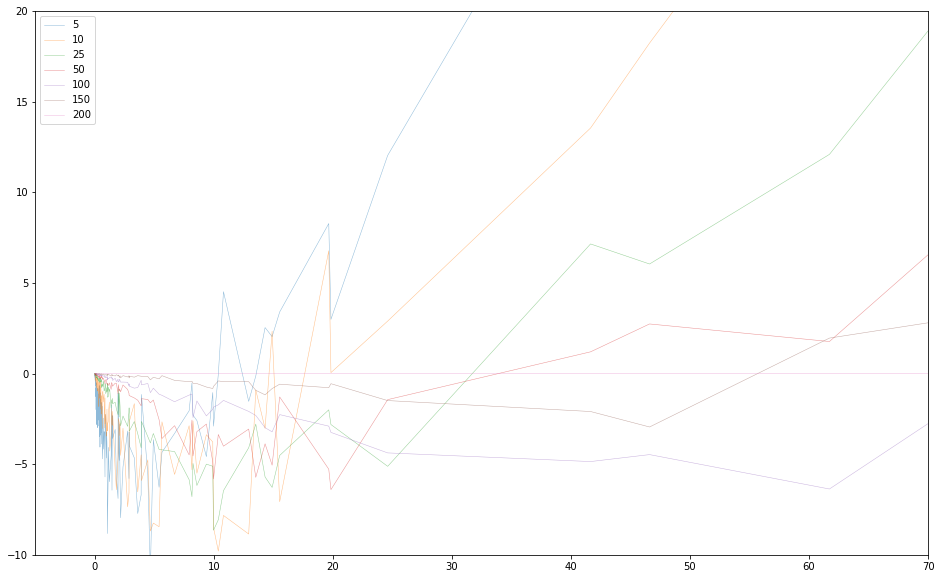

In [205]:
true_massing = probs_true.sum(axis=0)
order = true_massing.argsort()[::-1]

fig, ax = plt.subplots(figsize=(16,10))
for sample_size in samp_sizes[::-1]:
    if sample_size < 5:
        continue
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    sampled_massing = probs_samp_sparse.sum(axis=0)
    massing_err = (true_massing - sampled_massing)
    ax.plot(true_massing[order], massing_err[order], label=str(sample_size), lw=0.5, alpha=0.5)
#     corr_coeff = str(onp.round(float(onp.corrcoef(true_massing, sampled_massing)[0,1]), 2))
#     ax.scatter(true_massing, sampled_massing, marker='o', alpha=0.4, label=str(sample_size) + ' (corr. coef.: {0})'.format(corr_coeff), s=50)
#     ax.set_ylim(-1, 15)
#     ax.set_xlim(-1, 15)
#     ax.set_ylabel('with sampling')
#     ax.set_xlabel('no sampling')
#     ax.set_title('probability massing of alternatives')
#     ax.legend(title='sample size')
    
lims = [
    min(min(ax.get_xlim()), min(ax.get_ylim())),  # min of both axes
    max(max(ax.get_xlim()), max(ax.get_ylim())),  # max of both axes
]

ax.legend()
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
ax.set_xlim(-5, 70)
ax.set_ylim(-10, 20)

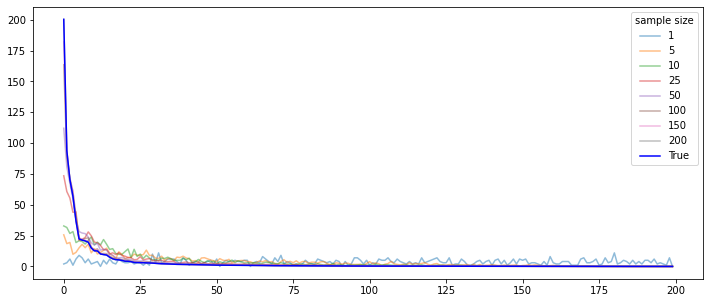

In [198]:
fig, ax = plt.subplots(figsize=(12,5))
order = probs_true.sum(axis=0).argsort()[::-1]

for sample_size in samp_sizes[::-1]:
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']

    ax.plot(zones, probs_samp_sparse.sum(axis=0)[order], alpha=0.5, label=sample_size)
#     ax.plot(zones, np.sort(probs_samp_sparse.sum(axis=0))[::-1],alpha=1, label=sample_size)

ax.plot(zones, probs_true.sum(axis=0)[order], color='b', alpha=1, label='True')
ax.legend(title='sample size')

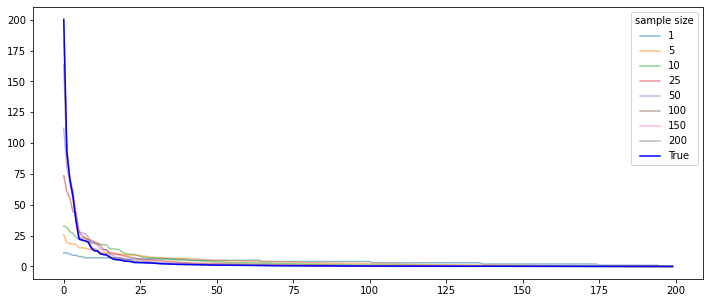

In [199]:
fig, ax = plt.subplots(figsize=(12,5))
order = probs_true.sum(axis=0).argsort()[::-1]

for sample_size in samp_sizes[::-1]:
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    ax.plot(zones, np.sort(probs_samp_sparse.sum(axis=0))[::-1],alpha=0.5, label=sample_size)

ax.plot(zones, probs_true.sum(axis=0)[order], color='b', alpha=1, label='True')
ax.legend(title='sample size')

(-5.0, 40.0)

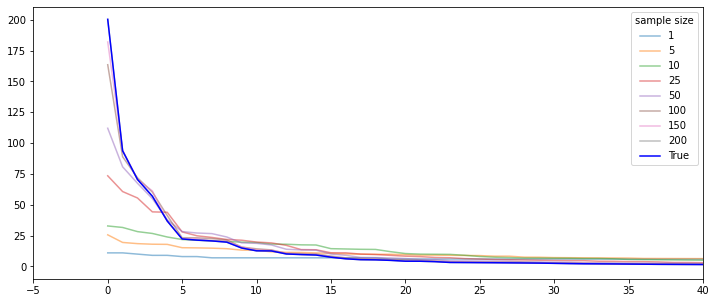

In [201]:
fig, ax = plt.subplots(figsize=(12,5))
order = probs_true.sum(axis=0).argsort()[::-1]

for sample_size in samp_sizes[::-1]:
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    ax.plot(zones, np.sort(probs_samp_sparse.sum(axis=0))[::-1],alpha=0.5, label=sample_size)

ax.plot(zones, probs_true.sum(axis=0)[order], color='b', alpha=1, label='True')
ax.legend(title='sample size')
ax.set_xlim(-5,40)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
order = probs_true.sum(axis=0).argsort()[::-1]

for sample_size in samp_sizes[::-1]:
    probs_samp_sparse = samp_probs_dict[sample_size]['probs_samp_sparse']
    samp_massing = probs_samp_sparse.sum(axis=0))
    , alpha=0.5, label=sample_size)

ax.plot(zones, probs_true.sum(axis=0)[order], color='b', alpha=1, label='True')
ax.legend(title='sample size')
ax.set_xlim(-5,40)

# Nerella and Bhat

Evaluation criteria:
- replicate choice probability of chosen alt
- reproduce aggregate shares of alternatives

Performance metrics:
1. RMSE
2. MAPE

Numerical properties across 10 runs of each sample size:
1. bias (mean diff of estimates)
2. simulation variance (of relevant params)
3. total error (diff between estimates and true values)

In [79]:
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable

In [85]:
obs_df = pd.DataFrame({'person_id': persons, 'zone_id': true_choices})

alts_df = pd.DataFrame(alts, columns=var_list,)
alts_df.index.name = 'zone_id'

mct = MergedChoiceTable(obs_df, alts_df, chosen_alternatives='zone_id')

results = MultinomialLogit(
    mct, model_expression='var1 + var2 + var3 + var4 + var5 - 1')

In [97]:
results.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            750
Model:         Multinomial Logit   Df Residuals:                745
Method:       Maximum Likelihood   Df Model:                      5
Date:                 2021-10-18   Pseudo R-squ.:             0.420
Time:                      13:10   Pseudo R-bar-squ.:         0.419
AIC:                   4,618.698   Log-Likelihood:       -2,304.349
BIC:                   4,641.799   LL-Null:              -3,973.738
             coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------
var1       0.9830     0.039    25.367     0.000             
var2       0.9937     0.040    24.880     0.000             
var3       1.0566     0.041    25.466     0.000             
var4       0.8801     0.054    16.310     0.000             
var5       1.0740     0.034    31.392     0.000             